In [ ]:
%pip install netCDF4
%pip install cartopy
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 29.6 MB/s eta 0:00:00


# Function to read the netCDF Data files

In [ ]:
import numpy as np
import pandas as pd
import netCDF4
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import pearsonr
# Function to load NetCDF data
def read_nc(filename):
    """
    Function read_nc
    Read a monthly climate data netCDF file and extract map series and dates
    :param filename: filename as a string
    :returns: (map series: numpy array(month,lat,lon), dates: list[(year,month)])
    """
    nc = netCDF4.Dataset(filename)
    # the temperature data could be called different things -
    # this trick picks the data element with the highest number of dimensions
    key = sorted([(nc.variables[k].ndim, k) for k in nc.variables])[-1][1]
    tmaps = np.ma.filled(nc.variables[key][:, :, :], np.nan)
    time1 = nc.variables["time"][:]
    unit1 = nc.variables["time"].units
    latitudes = nc.variables["latitude"][:]
    longitudes = nc.variables["longitude"][:]
    dates = netCDF4.num2date(time1, units=unit1)
    dates = pd.to_datetime([str(date) for date in dates])
    return tmaps, dates, latitudes, longitudes

In [ ]:
# Load the data
tmaps_crutem, dates_crutem, latitudes_crutem, longitudes_crutem = read_nc("/content/drive/MyDrive/Project_files/Netcdf files/CRUTEM.5.0.2.0.anomalies (1).nc")
tmaps_hadnmat, dates_hadnmat, latitudes_hadnmat, longitudes_hadnmat = read_nc("/content/drive/MyDrive/Project_files/Netcdf files/HadNMAT.2.0.1.0.nc")

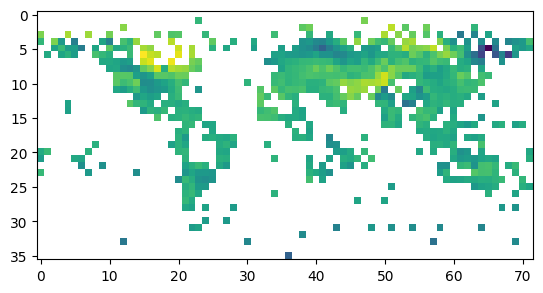

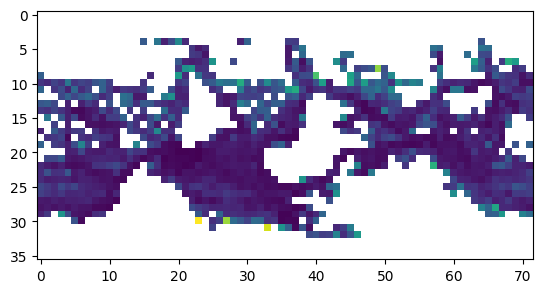

In [ ]:
# check coverage
plt.imshow(tmaps_crutem[-1,::-1,:])
plt.show()
plt.imshow(tmaps_hadnmat[-1,::-1,:])
plt.show()

In [ ]:
# Check the date ranges in the original datasets
print("CRUTEM dates range:", dates_crutem.min(), "to", dates_crutem.max())
print("HadNMAT dates range:", dates_hadnmat.min(), "to", dates_hadnmat.max())

CRUTEM dates range: 1850-01-16 12:00:00 to 2024-01-16 12:00:00
HadNMAT dates range: 1880-01-16 12:00:00 to 2010-12-16 12:00:00


In [ ]:
# Match lengths and align dates
start_date = max(dates_crutem.min(), dates_hadnmat.min())
end_date = min(dates_crutem.max(), dates_hadnmat.max())

In [ ]:
# Truncate to the common date range
common_mask_crutem = (dates_crutem >= start_date) & (dates_crutem <= end_date)
common_mask_hadnmat = (dates_hadnmat >= start_date) & (dates_hadnmat <= end_date)

In [ ]:
dates_crutem = dates_crutem[common_mask_crutem]
dates_hadnmat = dates_hadnmat[common_mask_hadnmat]

tmaps_crutem = tmaps_crutem[common_mask_crutem, :, :]
tmaps_hadnmat = tmaps_hadnmat[common_mask_hadnmat, :, :]

In [ ]:
# Check the date ranges after truncation
print("Truncated CRUTEM dates range:", dates_crutem.min(), "to", dates_crutem.max())
print("Truncated HadNMAT dates range:", dates_hadnmat.min(), "to", dates_hadnmat.max())

Truncated CRUTEM dates range: 1880-01-16 12:00:00 to 2010-12-16 12:00:00
Truncated HadNMAT dates range: 1880-01-16 12:00:00 to 2010-12-16 12:00:00


# Function to reduce the grid size to 10 degree grid

In [ ]:
# Reduce grid size
def reduce_grid_size(tmaps):
    tmaps_reduced = tmaps.reshape([tmaps.shape[0], tmaps.shape[1] // 2, 2, tmaps.shape[2] // 2, 2])
    tmaps_reduced = np.nanmean(tmaps_reduced, axis=(2, 4))
    return tmaps_reduced

In [ ]:
tmaps_crutem_reduced = reduce_grid_size(tmaps_crutem)
tmaps_hadnmat_reduced = reduce_grid_size(tmaps_hadnmat)

<ipython-input-10-f00f1edeba9a>:4: RuntimeWarning: Mean of empty slice
  tmaps_reduced = np.nanmean(tmaps_reduced, axis=(2, 4))


In [ ]:
# Define reduced latitudes and longitudes
reduced_latitudes = latitudes_crutem[::2]
reduced_longitudes = longitudes_crutem[::2]

In [ ]:
# get time series and derivatives from monthly means with incomplete data
def series_from_monthly_means(ymean, end_na=1):
  """
  Function series_from_monthly_means
  Take a series of monthly means are return monthly centre value and derivative
  :param ymean: time series of monthly means
  :param end_na: number of points to set to NA at the ends of the series (default:1)
  :returns: (time series of values, time series of derivative)
  """
  n = len(ymean)
  tmat = (1.0 * np.eye(n, n, -1) + 4.0 * np.eye(n, n, 0) + 1.0 * np.eye(n, n, 1)) / 6.0
  cp = np.linalg.solve(tmat, ymean)
  y = np.convolve(cp, [1.0 / 8.0, 6.0 / 8.0, 1.0 / 8.0], mode="same")
  dy = np.convolve(cp, [0.5, 0.0, -0.5], mode="same")
  if end_na:
      y[: end_na] = np.nan
      y[-end_na:] = np.nan
      dy[: end_na] = np.nan
      dy[-end_na:] = np.nan
  return y, dy

In [ ]:
# Function to calculate series with incomplete data
def series_from_monthly_means_incomplete(ymean, end_na=1, min_obs=12 ):
  """
  Function series_from_monthly_means_incomplete
  Take a series of monthly means are return monthly centre value and derivative
  :param ymean: time series of monthly means
  :param end_na: number of points to set to NA at the ends of the series (default:1)
  :returns: (time series of values, time series of derivative)
  """
  # get indices of non-missings
  i0 = np.nonzero(~np.isnan(ymean))[0]
  # find non-missing ranges
  i1 = np.roll(i0, 1)+1
  i2 = np.roll(i0,-1)-1
  i1 = i0[np.nonzero(i0!=i1)[0]]  # range start
  i2 = i0[np.nonzero(i0!=i2)[0]]  # range end
  assert np.sum(i2-i1+1) == np.count_nonzero(~np.isnan(ymean))
  # output arrays
  yfull  = np.full_like(ymean,np.nan)
  dyfull = np.full_like(ymean,np.nan)
  # gather data from ranges
  for i in range(len(i1)):
    # check there are sufficient data in range
    if (i2[i]-i1[i]>min_obs):
      #print(i0,i1[i],i2[i])
      yrange = ymean[i1[i]:i2[i]+1]
      y,dy = series_from_monthly_means(yrange,end_na)
      yfull[i1[i]:i2[i]+1]  = y
      dyfull[i1[i]:i2[i]+1] = dy
  return yfull,dyfull

In [ ]:
# Select the date ranges manually for each period
start_date_1970_1990 = pd.to_datetime('1970-01-16')
end_date_1970_1990 = pd.to_datetime('1990-12-16')

start_date_1990_2010 = pd.to_datetime('1990-01-16')
end_date_1990_2010 = pd.to_datetime('2010-12-16')

In [ ]:
mask_1970_1990 = (dates_crutem >= start_date_1970_1990) & (dates_crutem <= end_date_1970_1990)
mask_1990_2010 = (dates_crutem >= start_date_1990_2010) & (dates_crutem <= end_date_1990_2010)

In [ ]:
dates_range_1970_1990 = dates_crutem[mask_1970_1990]
dates_range_1990_2010 = dates_crutem[mask_1990_2010]

In [ ]:
tmaps_crutem_range_1970_1990 = tmaps_crutem_reduced[mask_1970_1990, :, :]
tmaps_hadnmat_range_1970_1990 = tmaps_hadnmat_reduced[mask_1970_1990, :, :]

tmaps_crutem_range_1990_2010 = tmaps_crutem_reduced[mask_1990_2010, :, :]
tmaps_hadnmat_range_1990_2010 = tmaps_hadnmat_reduced[mask_1990_2010, :, :]

# Using the loop to find the values of To, Ts and thier derivatives then storing the values in new dataframe

In [ ]:
# Create dataframes for specific time ranges manually for 1970 to 1990
data_1970_1990 = []
for lat in range(tmaps_crutem_range_1970_1990.shape[1]):
    for lon in range(tmaps_crutem_range_1970_1990.shape[2]):
        crutem_series = tmaps_crutem_range_1970_1990[:, lat, lon]
        hadnmat_series = tmaps_hadnmat_range_1970_1990[:, lat, lon]

        y1, dy1 = series_from_monthly_means_incomplete(crutem_series, 1, 12) # land
        y2, dy2 = series_from_monthly_means_incomplete(hadnmat_series, 1, 12) # ocean

        for i in range(len(dates_range_1970_1990)):
            if not np.isnan(dy1[i]) and not np.isnan(dy2[i]):
                data_1970_1990.append({
                    'date': dates_range_1970_1990[i],
                    'dTo': dy2[i],
                    'To': y2[i],
                    'dTs': dy1[i],
                    'Ts': y1[i],
                    'lat': lat,
                    'lon': lon
                })

df_1970_1990 = pd.DataFrame(data_1970_1990)


In [ ]:
df_1970_1990

,date,dTo,To,dTs,Ts,lat,lon
0,1970-02-15 00:00:00,-0.782857,2.279799,-0.749018,-0.803375,2,12
1,1970-03-16 12:00:00,-0.188888,0.051734,0.151680,-1.054969,2,12
2,1970-04-16 00:00:00,0.648534,1.962886,-0.524700,-0.894285,2,12
3,1970-05-16 12:00:00,-0.233915,0.918835,-1.654021,-2.217605,2,12
4,1970-06-16 00:00:00,0.444756,1.885337,4.222786,-2.450796,2,12
...,...,...,...,...,...,...,...
42014,1985-11-16 00:00:00,0.005852,0.873875,-1.088525,1.658544,14,35
42015,1985-12-16 12:00:00,-0.174681,0.255194,-1.035427,0.058032,14,35
42016,1986-01-16 12:00:00,0.296799,0.687516,0.709232,0.010580,14,35
42017,1986-02-15 00:00:00,-0.045004,0.645472,0.490500,0.985647,14,35


In [ ]:
# Create dataframes for specific time ranges manually for 1990 to 2010

data_1990_2010 = []
for lat in range(tmaps_crutem_range_1990_2010.shape[1]):
    for lon in range(tmaps_crutem_range_1990_2010.shape[2]):
        crutem_series = tmaps_crutem_range_1990_2010[:, lat, lon]
        hadnmat_series = tmaps_hadnmat_range_1990_2010[:, lat, lon]

        y1, dy1 = series_from_monthly_means_incomplete(crutem_series, 1, 12) # land
        y2, dy2 = series_from_monthly_means_incomplete(hadnmat_series, 1, 12) # ocean

        for i in range(len(dates_range_1990_2010)):
            if not np.isnan(dy1[i]) and not np.isnan(dy2[i]):
                data_1990_2010.append({
                    'date': dates_range_1990_2010[i],
                    'dTo': dy2[i],
                    'To': y2[i],
                    'dTs': dy1[i],
                    'Ts': y1[i],
                    'lat': lat,
                    'lon': lon
                })

df_1990_2010 = pd.DataFrame(data_1990_2010)

In [ ]:
df_1990_2010

,date,dTo,To,dTs,Ts,lat,lon
0,1993-02-15 00:00:00,-0.299381,1.243485,0.420577,1.137124,2,12
1,1993-03-16 12:00:00,0.262422,1.255493,-0.555099,0.575040,2,12
2,1993-04-16 00:00:00,-0.165950,1.520786,0.865534,0.626003,2,12
3,1993-05-16 12:00:00,0.079509,1.092050,0.269962,1.802057,2,12
4,1993-06-16 00:00:00,0.037118,1.607842,-0.192954,1.199091,2,12
...,...,...,...,...,...,...,...
31315,2005-10-16 12:00:00,-0.056063,0.198101,0.462272,1.590330,14,12
31316,2005-11-16 00:00:00,0.217159,0.162977,-0.266578,1.850407,14,12
31317,2005-12-16 12:00:00,-0.005974,0.508330,1.776440,1.750141,14,12
31318,2006-01-16 12:00:00,-0.064305,0.192230,-1.314983,4.119677,14,12


In [ ]:
# Checking the size of dataframes to ensure the data is being captured correctly
print(f"Size of dataframe from 1970-1990: {df_1970_1990.shape}")
print(f"Size of dataframe from 1990-2010: {df_1990_2010.shape}")

Size of dataframe from 1970-1990: (42019, 7)
Size of dataframe from 1990-2010: (31320, 7)


In [ ]:
# Preprocessing the  dataframes
df_1970_1980 = df_1970_1990.sort_values(by='date')
df_1970_1980 = df_1970_1980.dropna(subset=['dTs', 'To', 'Ts', 'dTo'])
df_1970_1980.reset_index(drop=True, inplace=True)

df_1980_1990 = df_1990_2010.sort_values(by='date')
df_1980_1990 = df_1980_1990.dropna(subset=['dTs', 'To', 'Ts', 'dTo'])
df_1980_1990.reset_index(drop=True, inplace=True)

In [ ]:
# Calculating the  coefficients for the two time ranges manually
A_grid_1970_1990 = np.full((tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2]), np.nan)
B_grid_1970_1990 = np.full((tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2]), np.nan)
C_grid_1970_1990 = np.full((tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2]), np.nan)

A_grid_1990_2010 = np.full((tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2]), np.nan)
B_grid_1990_2010 = np.full((tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2]), np.nan)
C_grid_1990_2010 = np.full((tmaps_crutem_reduced.shape[1], tmaps_crutem_reduced.shape[2]), np.nan)


# Calculating the grid values A, B, C by fitting the temperature anomalies and thier derivatives in OLS regression

In [ ]:
for lat in range(tmaps_crutem_reduced.shape[1]):
    for lon in range(tmaps_crutem_reduced.shape[2]):
        grid_data_1970_1990 = df_1970_1980[(df_1970_1990['lat'] == lat) & (df_1970_1990['lon'] == lon)]
        if len(grid_data_1970_1990) >= 200:
            # construct equations
            y = grid_data_1970_1990['dTo']
            X = grid_data_1970_1990[['dTs', 'To', 'Ts']]
            X = sm.add_constant(X)  # Adding the constant term
            model = sm.OLS(y, X).fit()
            A_grid_1970_1990[lat, lon] = model.params['dTs']
            B_grid_1970_1990[lat, lon] = -model.params['To']/2.63e6
            C_grid_1970_1990[lat, lon] = model.params['Ts']/2.63e6

        grid_data_1990_2010 = df_1980_1990[(df_1990_2010['lat'] == lat) & (df_1990_2010['lon'] == lon)]
        if len(grid_data_1990_2010) >= 200:
            # construct equations
            y = grid_data_1990_2010['dTo']
            X = grid_data_1990_2010[['dTs', 'To', 'Ts']]
            X = sm.add_constant(X)  # Adding the constant term
            model = sm.OLS(y, X).fit()
            A_grid_1990_2010[lat, lon] = model.params['dTs']
            B_grid_1990_2010[lat, lon] = -model.params['To']/2.63e6
            C_grid_1990_2010[lat, lon] = model.params['Ts']/2.63e6

# Displaying the Coefficeint Values of A, B, C from the period 1970-1990

In [ ]:
A_grid_1970_1990, B_grid_1970_1990, C_grid_1970_1990

(array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
               

# Displaying the Coefficeint Values of A, B, C from the period 1990-2010

In [ ]:
A_grid_1990_2010, B_grid_1990_2010, C_grid_1990_2010

(array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
               

# Outlier detection and removing those for final analysis using Z score and iqr methods

In [ ]:
# Creating function to identify the outliers
def identify_outliers(data, method='zscore', threshold=3):
    if method == 'zscore':
        mean = np.nanmean(data)
        std = np.nanstd(data)
        z_scores = (data - mean) / std
        outliers = np.abs(z_scores) > threshold
    elif method == 'iqr':
        q1 = np.nanpercentile(data, 25)
        q3 = np.nanpercentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
    else:
        raise ValueError("Unsupported method. Choose 'zscore' or 'iqr'.")
    return outliers

In [ ]:
#create function to remove the outliers

def remove_outliers(data, outliers):
    data_cleaned = np.copy(data)
    data_cleaned[outliers] = np.nan
    return data_cleaned

In [ ]:
# Identify outliers in the A, B, and C coefficient grids
outliers_A_1970_1990 = identify_outliers(A_grid_1970_1990, method='zscore', threshold=3)
outliers_B_1970_1990 = identify_outliers(B_grid_1970_1990, method='zscore', threshold=3)
outliers_C_1970_1990 = identify_outliers(C_grid_1970_1990, method='zscore', threshold=3)

outliers_A_1990_2010 = identify_outliers(A_grid_1990_2010, method='zscore', threshold=3)
outliers_B_1990_2010 = identify_outliers(B_grid_1990_2010, method='zscore', threshold=3)
outliers_C_1990_2010 = identify_outliers(C_grid_1990_2010, method='zscore', threshold=3)

In [ ]:
# Remove outliers from the grids
A_grid_cleaned_1970_1990 = remove_outliers(A_grid_1970_1990, outliers_A_1970_1990)
B_grid_cleaned_1970_1990 = remove_outliers(B_grid_1970_1990, outliers_B_1970_1990)
C_grid_cleaned_1970_1990 = remove_outliers(C_grid_1970_1990, outliers_C_1970_1990)

A_grid_cleaned_1990_2010 = remove_outliers(A_grid_1990_2010, outliers_A_1990_2010)
B_grid_cleaned_1990_2010 = remove_outliers(B_grid_1990_2010, outliers_B_1990_2010)
C_grid_cleaned_1990_2010 = remove_outliers(C_grid_1990_2010, outliers_C_1990_2010)


# Function for Scatterplot analysis


In [ ]:
# Function to scatter plot coefficients without outliers
def scatter_plot_coefficients(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(6, 6))
    plt.plot(x, y, 'o')
    plt.axline((0, 0), slope=1, color="k")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axis('square')
    plt.grid(True)
    plt.show()

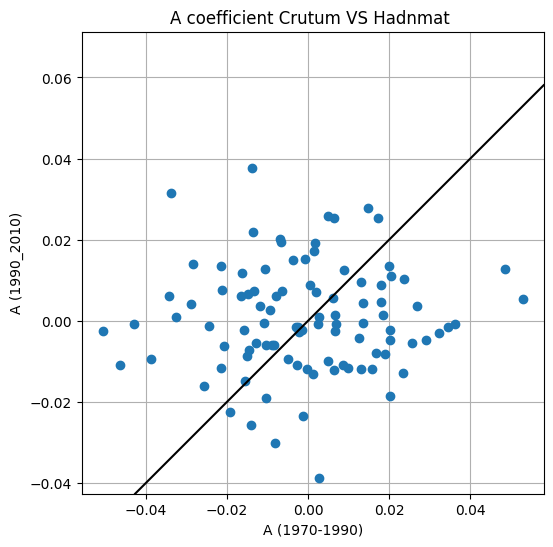

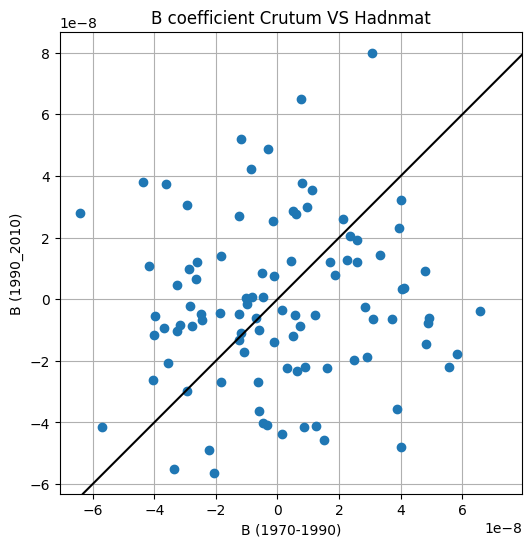

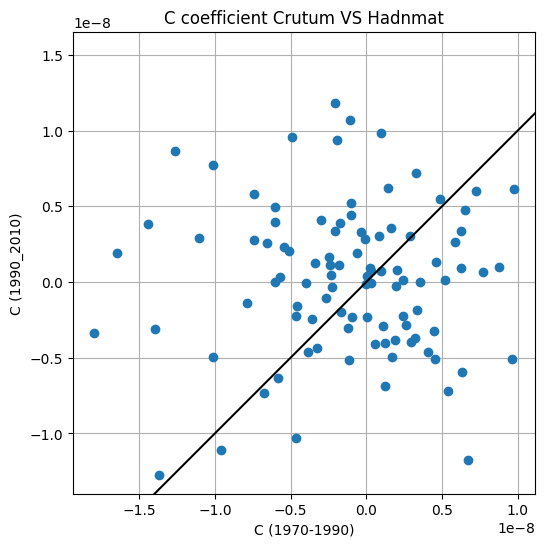

In [ ]:
# Flatten the cleaned coefficient grids for comparison
A_1970_1990_flat_cleaned = A_grid_cleaned_1970_1990.flatten()
A_1990_2010_flat_cleaned = A_grid_cleaned_1990_2010.flatten()

B_1970_1990_flat_cleaned = B_grid_cleaned_1970_1990.flatten()
B_1990_2010_flat_cleaned = B_grid_cleaned_1990_2010.flatten()

C_1970_1990_flat_cleaned = C_grid_cleaned_1970_1990.flatten()
C_1990_2010_flat_cleaned = C_grid_cleaned_1990_2010.flatten()

# Scatter plot comparison for A coefficients without outliers
scatter_plot_coefficients(A_1970_1990_flat_cleaned, A_1990_2010_flat_cleaned,
                          "A coefficient Crutum VS Hadnmat ",
                          "A (1970-1990)", "A (1990_2010)")

# Scatter plot comparison for B coefficients without outliers
scatter_plot_coefficients(B_1970_1990_flat_cleaned, B_1990_2010_flat_cleaned,
                          "B coefficient Crutum VS Hadnmat",
                          "B (1970-1990)", "B (1990_2010)")

# Scatter plot comparison for C coefficients without outliers
scatter_plot_coefficients(C_1970_1990_flat_cleaned, C_1990_2010_flat_cleaned,
                          "C coefficient Crutum VS Hadnmat",
                          "C (1970-1990)", "C (1990_2010)")

# Function for Spatial coefficeint analysis

In [ ]:
def plot_coefficient_spatially(latitudes, longitudes, coefficient, title, scale_factor=1, unit=''):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    lons, lats = np.meshgrid(longitudes, latitudes)
    c = ax.pcolormesh(lons, lats, coefficient * scale_factor, cmap='coolwarm', shading='auto', vmin=np.nanmin(coefficient * scale_factor), vmax=np.nanmax(coefficient * scale_factor))
    ax.coastlines()
    ax.set_title(title)
    cbar = fig.colorbar(c, ax=ax, orientation='vertical', pad=0.05, location='left')
    cbar.set_label(unit)
    plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


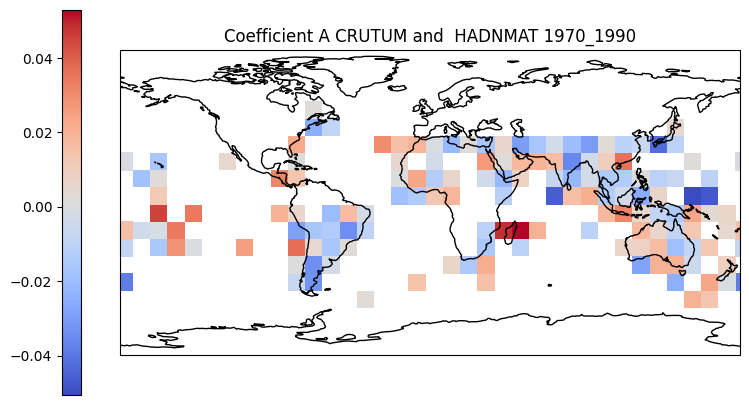

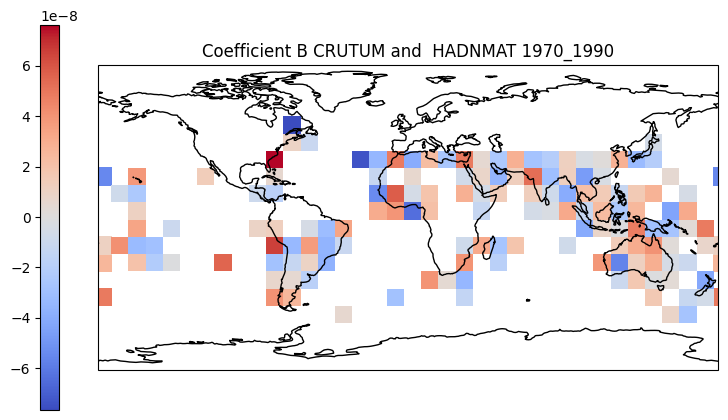

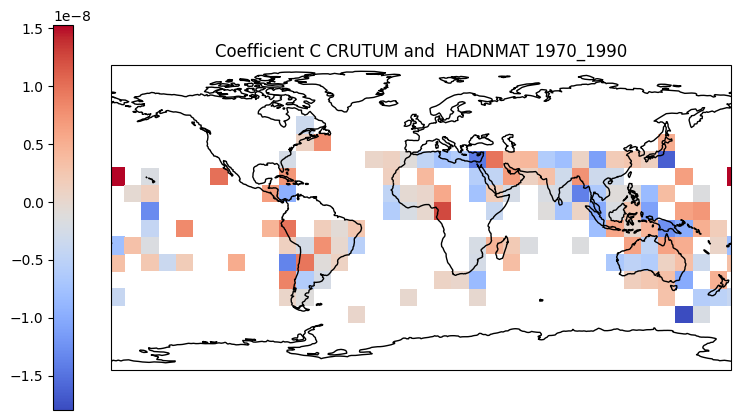

In [ ]:
# Plot the spatial distribution of the coefficients
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, A_grid_cleaned_1970_1990, "Coefficient A CRUTUM and  HADNMAT 1970_1990")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, B_grid_cleaned_1970_1990, "Coefficient B CRUTUM and  HADNMAT 1970_1990")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, C_grid_cleaned_1970_1990, "Coefficient C CRUTUM and  HADNMAT 1970_1990")

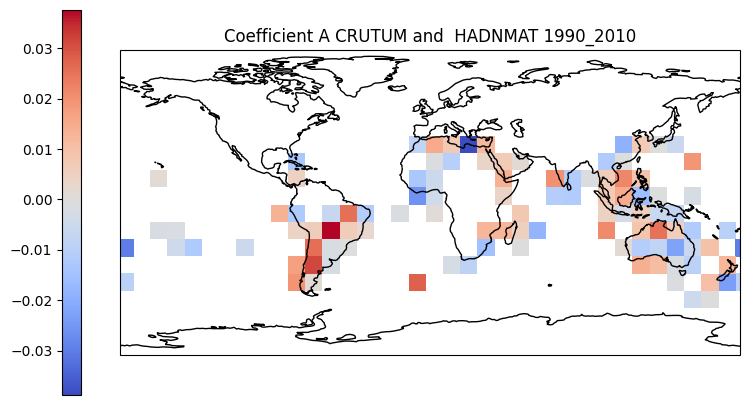

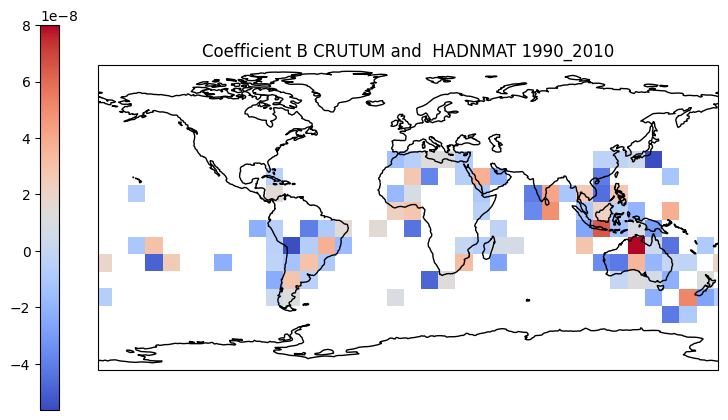

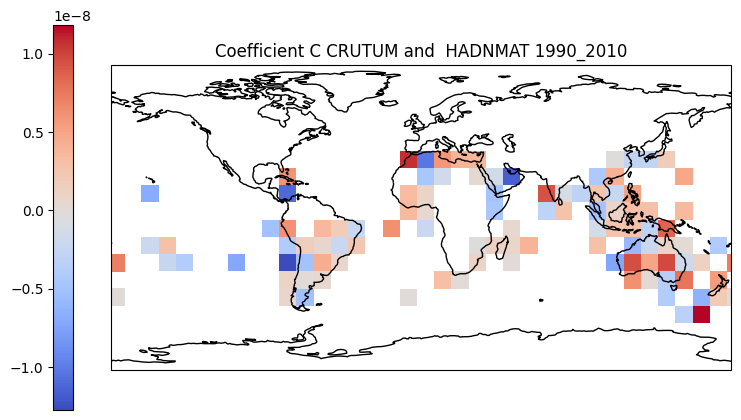

In [ ]:
# Plot the spatial distribution of the coefficients
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, A_grid_cleaned_1990_2010, "Coefficient A CRUTUM and  HADNMAT 1990_2010")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, B_grid_cleaned_1990_2010, "Coefficient B CRUTUM and  HADNMAT 1990_2010")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, C_grid_cleaned_1990_2010, "Coefficient C CRUTUM and  HADNMAT 1990_2010")

# Function for Latitidinal boxplot with median

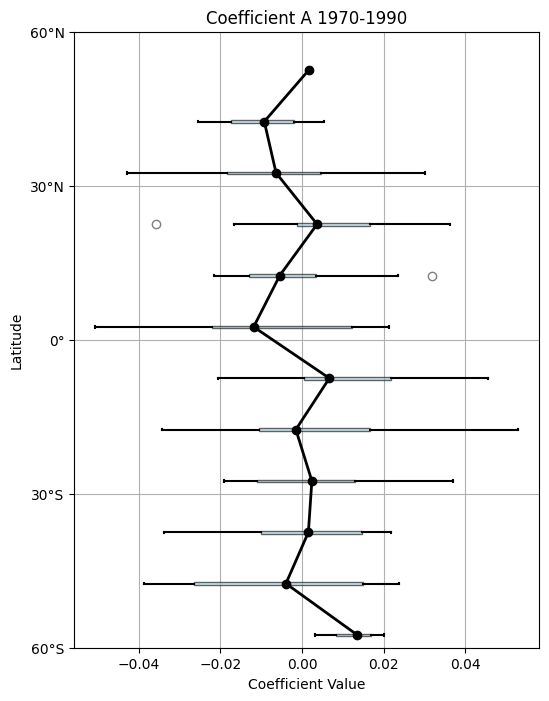

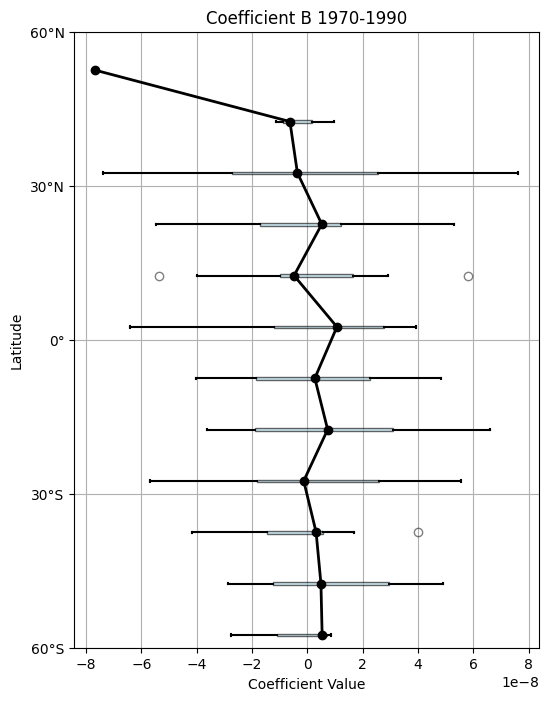

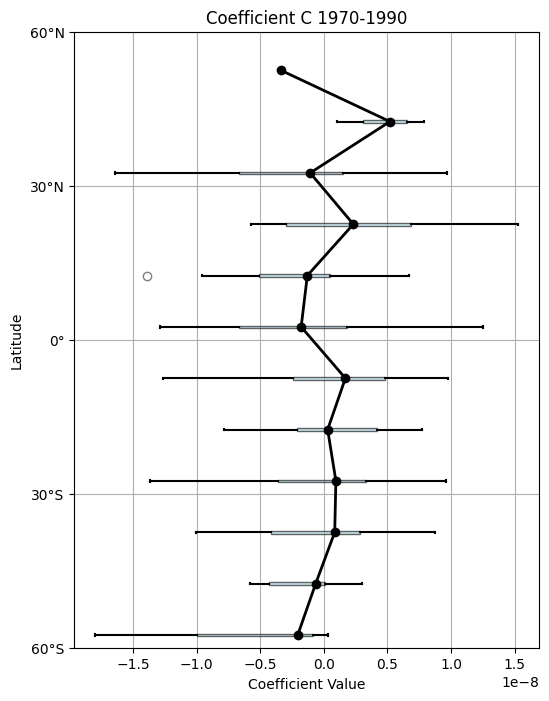

In [ ]:
def plot_custom_boxplot_with_medians(coefficient, latitudes, title):
    # Convert data to pandas DataFrame for easier processing
    df = pd.DataFrame({'Latitude': latitudes, 'Coefficient': coefficient})

    # Drop rows with NaN coefficient values
    df = df.dropna(subset=['Coefficient'])

    plt.figure(figsize=(6, 8))

    # Prepare data for boxplot
    latitude_bins = np.unique(df['Latitude'])
    boxplot_data = [df[df['Latitude'] == lat]['Coefficient'].dropna() for lat in latitude_bins]

    # Create the boxplot
    box = plt.boxplot(boxplot_data, vert=False, positions=latitude_bins, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='black'),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', color='black', alpha=0.5))

    # Shading for the interquartile range (IQR)
    for patch in box['boxes']:
        patch.set(facecolor='lightblue', alpha=0.6)

    # Whiskers and caps
    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=1.5)

    for cap in box['caps']:
        cap.set(color='black', linewidth=1.5)

    # Median line properties
    for median in box['medians']:
        median.set(color='black', linewidth=2)

    # Plotting outliers
    for flier in box['fliers']:
        flier.set(marker='o', color='black', alpha=0.5)

    # Calculating the median for each latitude bin
    median_coefficients = [data.median() for data in boxplot_data]

    # Plot the median line with connecting points
    plt.plot(median_coefficients, latitude_bins, 'o-', color='black', linewidth=2)

    # Set y-axis to specific ticks
    plt.yticks(ticks=np.arange(-60, 70, 30), labels=['60°S', '30°S', '0°', '30°N', '60°N'])

    # Set x-axis label, y-axis label, and title
    plt.xlabel('Coefficient Value')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_custom_boxplot_with_medians(A_grid_cleaned_1970_1990.flatten(), np.repeat(reduced_latitudes, A_grid_cleaned_1970_1990.shape[1]), "Coefficient A 1970-1990")
plot_custom_boxplot_with_medians(B_grid_cleaned_1970_1990.flatten(), np.repeat(reduced_latitudes, B_grid_cleaned_1970_1990.shape[1]), "Coefficient B 1970-1990")
plot_custom_boxplot_with_medians(C_grid_cleaned_1970_1990.flatten(), np.repeat(reduced_latitudes, C_grid_cleaned_1970_1990.shape[1]), "Coefficient C 1970-1990")


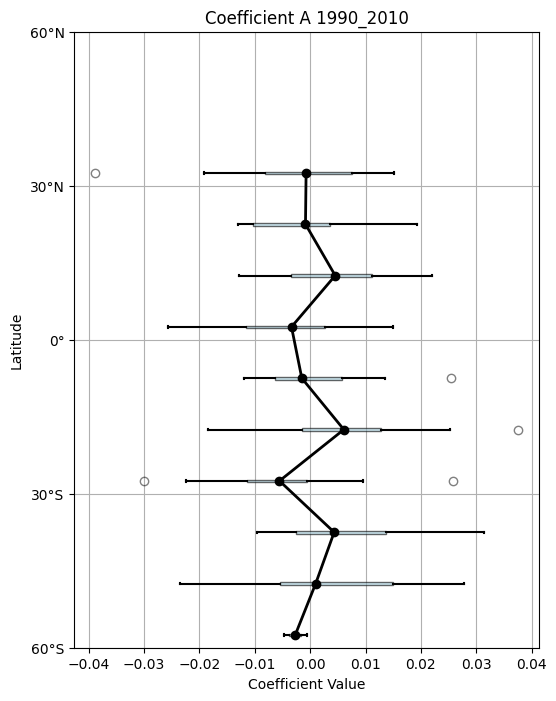

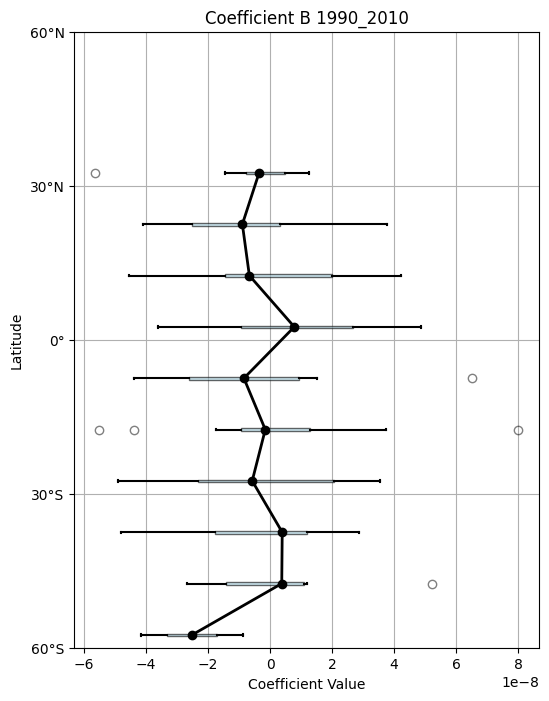

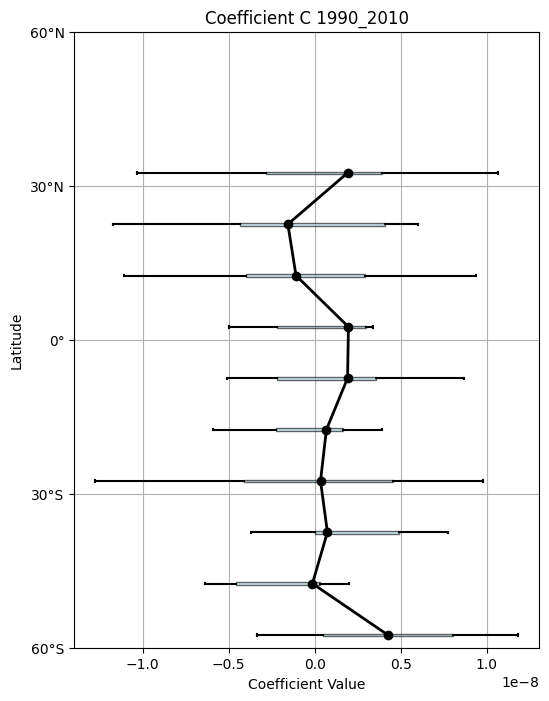

In [ ]:
plot_custom_boxplot_with_medians(A_grid_cleaned_1990_2010.flatten(), np.repeat(reduced_latitudes, A_grid_cleaned_1990_2010.shape[1]), "Coefficient A 1990_2010")
plot_custom_boxplot_with_medians(B_grid_cleaned_1990_2010.flatten(), np.repeat(reduced_latitudes, B_grid_cleaned_1990_2010.shape[1]), "Coefficient B 1990_2010")
plot_custom_boxplot_with_medians(C_grid_cleaned_1990_2010.flatten(), np.repeat(reduced_latitudes, C_grid_cleaned_1990_2010.shape[1]), "Coefficient C 1990_2010")

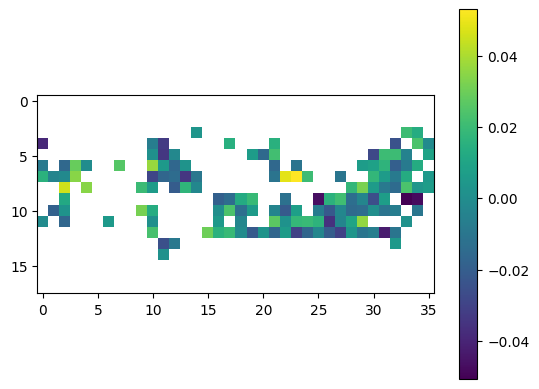

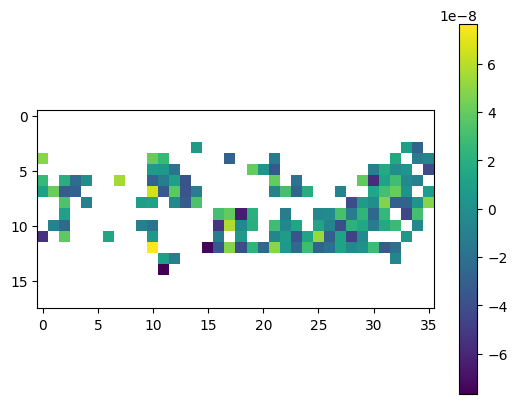

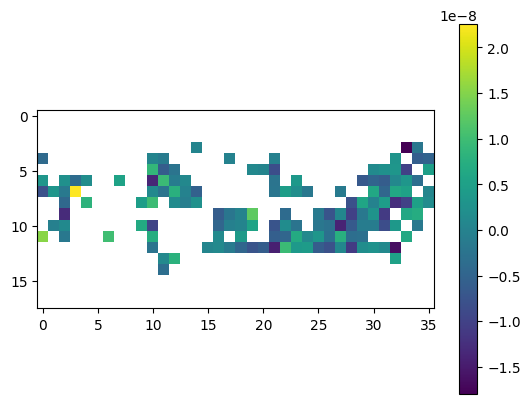

In [ ]:
plt.imshow(A_grid_1970_1990)
plt.colorbar()
plt.show()
plt.imshow(B_grid_1970_1990)
plt.colorbar()
plt.show()
plt.imshow(C_grid_1970_1990)
plt.colorbar()
plt.show()

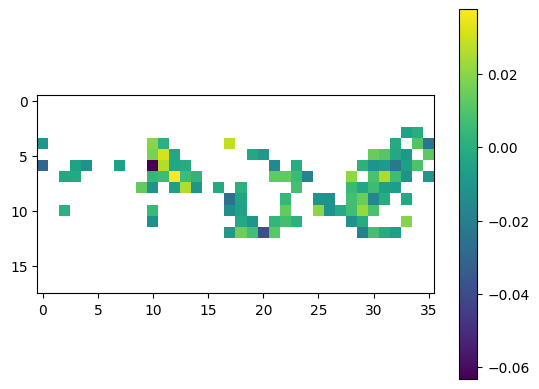

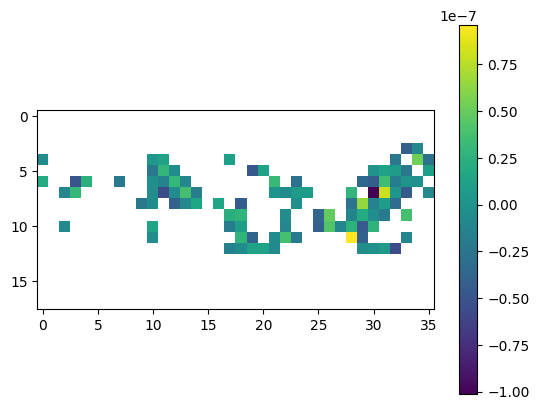

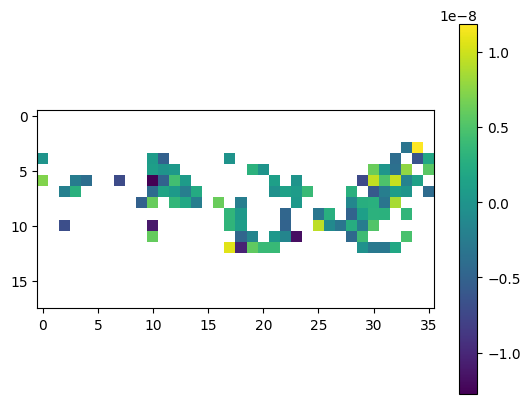

In [ ]:
plt.imshow(A_grid_1990_2010)
plt.colorbar()
plt.show()
plt.imshow(B_grid_1990_2010)
plt.colorbar()
plt.show()
plt.imshow(C_grid_1990_2010)
plt.colorbar()
plt.show()

# Function for calculating the Pearson Correlation between two periods of Coefficient values(1970-1990 and 1990-2010)

In [ ]:
from scipy.stats import pearsonr
import numpy as np

# Flatten the arrays and remove NaN values for correlation calculation
def calculate_pearson_correlation(coef_1970_1990, coef_1990_2010):
    flat_1970_1990 = coef_1970_1990.flatten()
    flat_1990_2010 = coef_1990_2010.flatten()

    # Remove NaNs from both arrays
    mask = ~np.isnan(flat_1970_1990) & ~np.isnan(flat_1990_2010)
    clean_1970_1990 = flat_1970_1990[mask]
    clean_1990_2010 = flat_1990_2010[mask]

    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(clean_1970_1990, clean_1990_2010)
    return correlation

# Calculate Pearson correlation coefficients for A, B, and C grids
pearson_A = calculate_pearson_correlation(A_grid_1970_1990, A_grid_1990_2010)
pearson_B = calculate_pearson_correlation(B_grid_1970_1990, B_grid_1990_2010)
pearson_C = calculate_pearson_correlation(C_grid_1970_1990, C_grid_1990_2010)

print("Pearson coefficient of grid values for Crutum VS Hadnmat 1970-1990 and 1990-2010")
print("Pearson Correlation Coefficient for Coefficient A:", pearson_A)
print("Pearson Correlation Coefficient for Coefficient B:", pearson_B)
print("Pearson Correlation Coefficient for Coefficient C:", pearson_C)


Pearson coefficient of grid values for Crutum VS Hadnmat 1970-1990 and 1990-2010
Pearson Correlation Coefficient for Coefficient A: -0.05139424409987803
Pearson Correlation Coefficient for Coefficient B: -0.030877168175432568
Pearson Correlation Coefficient for Coefficient C: 0.023951036626386982
